#install necessary libraries

In [ ]:
!pip install torch cairosvg opencv-python-headless segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import Libraries

In [ ]:

# Step 2: Imports
import os
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
#import cairosvg
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import segmentation_models_pytorch as smp
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [ ]:
import os
from glob import glob

# Set the root directory
root_dir = r'/content/drive/MyDrive/Zebrafish Segmentation'
#root_dir = r'D:\OneDrive - The Pennsylvania State University\Research DATA\Zebrafish Data\Zebrafish Segmentation'

# Recursively find all .tif (image) and .png (mask) files
image_paths = glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)
mask_paths = glob(os.path.join(root_dir, '**', '*.png'), recursive=True)

# Build lookup dictionaries using the filename without extension as key
image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
mask_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in mask_paths}

# Get only the common filenames that exist in both
common_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

# Filter matched pairs
matched_image_paths = [image_dict[k] for k in common_keys]
matched_mask_paths = [mask_dict[k] for k in common_keys]

# Display final matched count
print(f"Total matched image-mask pairs: {len(matched_image_paths)}")

# Optionally display the first few matches
for i in range(min(5, len(matched_image_paths))):
    print(f"Image: {matched_image_paths[i]}")
    print(f"Mask : {matched_mask_paths[i]}")


Total matched image-mask pairs: 19
Image: /content/drive/MyDrive/Zebrafish Segmentation/7.8mm/Coronal/Image/16255-7.8mmC#9.tif
Mask : /content/drive/MyDrive/Zebrafish Segmentation/7.8mm/Coronal/Mask/All Organs/16255-7.8mmC#9.png
Image: /content/drive/MyDrive/Zebrafish Segmentation/7.8mm/Coronal/Image/16260-7.8mmC#14.tif
Mask : /content/drive/MyDrive/Zebrafish Segmentation/7.8mm/Coronal/Mask/All Organs/16260-7.8mmC#14.png
Image: /content/drive/MyDrive/Zebrafish Segmentation/7.8mm/Coronal/Image/16264-7.8mmC#16.tif
Mask : /content/drive/MyDrive/Zebrafish Segmentation/7.8mm/Coronal/Mask/All Organs/16264-7.8mmC#16.png
Image: /content/drive/MyDrive/Zebrafish Segmentation/3dpf/Coronal/Image/20_1727_10-3dpfC#10can.tif
Mask : /content/drive/MyDrive/Zebrafish Segmentation/3dpf/Coronal/Mask/Brain/20_1727_10-3dpfC#10can.png
Image: /content/drive/MyDrive/Zebrafish Segmentation/3dpf/Coronal/Image/20_1728_11-3dpfC#11can.tif
Mask : /content/drive/MyDrive/Zebrafish Segmentation/3dpf/Coronal/Mask/All Or

In [ ]:
#train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(matched_image_paths, matched_mask_paths, test_size=0.2, random_state=42)
print(len(train_imgs), len(val_imgs), len(train_masks), len(val_masks))

15 4 15 4


# check gpu

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Device: cuda
GPU Name: Tesla T4


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def get_transforms(
    use_flip=True,
    use_rotate=True,
    use_brightness=False,
    use_noise=False,
    image_height=256,
    image_width=256*4
):
    aug_list = []

    if use_flip:
        aug_list.append(A.HorizontalFlip(p=0.5))
        aug_list.append(A.VerticalFlip(p=0.5))

    if use_rotate:
        aug_list.append(A.Rotate(limit=30, p=0.5))  # Random rotation ±30 degrees

    if use_brightness:
        aug_list.append(A.RandomBrightnessContrast(p=0.5))

    if use_noise:
        aug_list.append(A.GaussNoise(p=0.5))

    # Always do resizing and normalization
    aug_list.extend([
        #A.Resize(image_size, image_size),
        A.Resize(height=image_height, width=image_width),
        A.Normalize(),
        ToTensorV2()
    ])

    return A.Compose(aug_list)


In [ ]:



print ("Dataset loading start ")
# Set device


# Assuming matched_image_paths and matched_mask_paths are defined already
# Ensure matching by file name (done earlier)
# Split into train and test (80/20)
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    matched_image_paths, matched_mask_paths, test_size=0.2, random_state=42
)

# Define Dataset
class ZebrafishDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('float32')  # Binary mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask

# Example config for training
train_transform = get_transforms(
    use_flip=True,
    use_rotate=True,
    use_brightness=False,
    use_noise=False
)

# For testing: only resize + normalize, no augmentation
test_transform = get_transforms(
    use_flip=False,
    use_rotate=False,
    use_brightness=False,
    use_noise=False
)


# Datasets and Loaders
train_dataset = ZebrafishDataset(train_imgs, train_masks, transform=train_transform)
test_dataset = ZebrafishDataset(test_imgs, test_masks, transform=test_transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Number of training data loader samples: {len(train_loader)}")
print(f"Number of testing  data loader samples: {len(test_loader)}")

print ("Dataset loading complete")

Dataset loading start 
Number of training samples: 15
Number of testing samples: 4
Number of training data loader samples: 4
Number of testing  data loader samples: 1
Dataset loading complete


Model loading start


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model loading complete

--- Epoch results ---


Training Epochs:   0%|          | 1/200 [01:05<3:36:12, 65.19s/it]

Epoch 1, Loss: 3.3624, Accuracy: 0.5809


Training Epochs:   1%|          | 2/200 [01:22<2:02:30, 37.12s/it]

Epoch 2, Loss: 3.0604, Accuracy: 0.7003


Training Epochs:   2%|▏         | 3/200 [01:40<1:32:22, 28.14s/it]

Epoch 3, Loss: 3.1161, Accuracy: 0.7094


Training Epochs:   2%|▏         | 4/200 [01:55<1:15:08, 23.00s/it]

Epoch 4, Loss: 2.8121, Accuracy: 0.7080


Training Epochs:   2%|▎         | 5/200 [02:12<1:08:34, 21.10s/it]

Epoch 5, Loss: 2.8801, Accuracy: 0.7237


Training Epochs:   3%|▎         | 6/200 [02:29<1:02:44, 19.40s/it]

Epoch 6, Loss: 2.6351, Accuracy: 0.7731


Training Epochs:   4%|▎         | 7/200 [02:44<58:32, 18.20s/it]  

Epoch 7, Loss: 2.4884, Accuracy: 0.8085


Training Epochs:   4%|▍         | 8/200 [03:01<56:38, 17.70s/it]

Epoch 8, Loss: 2.6053, Accuracy: 0.8065


Training Epochs:   4%|▍         | 9/200 [03:18<55:59, 17.59s/it]

Epoch 9, Loss: 2.8352, Accuracy: 0.8113


Training Epochs:   5%|▌         | 10/200 [03:35<55:16, 17.45s/it]

Epoch 10, Loss: 2.4479, Accuracy: 0.8300


Training Epochs:   6%|▌         | 11/200 [03:51<53:26, 16.96s/it]

Epoch 11, Loss: 2.4137, Accuracy: 0.8263


Training Epochs:   6%|▌         | 12/200 [04:08<52:27, 16.74s/it]

Epoch 12, Loss: 2.2467, Accuracy: 0.8668


Training Epochs:   6%|▋         | 13/200 [04:24<51:53, 16.65s/it]

Epoch 13, Loss: 2.3122, Accuracy: 0.8773


Training Epochs:   7%|▋         | 14/200 [04:40<51:29, 16.61s/it]

Epoch 14, Loss: 2.3163, Accuracy: 0.8824


Training Epochs:   8%|▊         | 15/200 [04:56<50:38, 16.43s/it]

Epoch 15, Loss: 2.4175, Accuracy: 0.8692


Training Epochs:   8%|▊         | 16/200 [05:12<49:07, 16.02s/it]

Epoch 16, Loss: 2.1435, Accuracy: 0.8829


Training Epochs:   8%|▊         | 17/200 [05:27<48:16, 15.83s/it]

Epoch 17, Loss: 2.4701, Accuracy: 0.8727


Training Epochs:   9%|▉         | 18/200 [05:44<48:49, 16.09s/it]

Epoch 18, Loss: 1.9617, Accuracy: 0.9137


Training Epochs:  10%|▉         | 19/200 [06:00<48:52, 16.20s/it]

Epoch 19, Loss: 2.3167, Accuracy: 0.8749


Training Epochs:  10%|█         | 20/200 [06:16<48:15, 16.08s/it]

Epoch 20, Loss: 2.0798, Accuracy: 0.9118


Training Epochs:  10%|█         | 21/200 [06:32<48:03, 16.11s/it]

Epoch 21, Loss: 2.2042, Accuracy: 0.8976


Training Epochs:  11%|█         | 22/200 [06:49<48:25, 16.32s/it]

Epoch 22, Loss: 2.2713, Accuracy: 0.9011


Training Epochs:  12%|█▏        | 23/200 [07:04<46:40, 15.82s/it]

Epoch 23, Loss: 1.7091, Accuracy: 0.9249


Training Epochs:  12%|█▏        | 24/200 [07:19<46:16, 15.78s/it]

Epoch 24, Loss: 1.7964, Accuracy: 0.9241


Training Epochs:  12%|█▎        | 25/200 [07:37<47:23, 16.25s/it]

Epoch 25, Loss: 2.2491, Accuracy: 0.9177


Training Epochs:  13%|█▎        | 26/200 [07:54<47:44, 16.46s/it]

Epoch 26, Loss: 2.0449, Accuracy: 0.9176


Training Epochs:  14%|█▎        | 27/200 [08:10<47:05, 16.33s/it]

Epoch 27, Loss: 2.1307, Accuracy: 0.9039


Training Epochs:  14%|█▍        | 28/200 [08:25<46:23, 16.18s/it]

Epoch 28, Loss: 1.8318, Accuracy: 0.9306


Training Epochs:  14%|█▍        | 29/200 [08:42<46:54, 16.46s/it]

Epoch 29, Loss: 1.8572, Accuracy: 0.9424


Training Epochs:  15%|█▌        | 30/200 [08:58<46:08, 16.28s/it]

Epoch 30, Loss: 2.0606, Accuracy: 0.9332


Training Epochs:  16%|█▌        | 31/200 [09:14<45:28, 16.15s/it]

Epoch 31, Loss: 1.8808, Accuracy: 0.9479


Training Epochs:  16%|█▌        | 32/200 [09:31<45:38, 16.30s/it]

Epoch 32, Loss: 1.9552, Accuracy: 0.9334


Training Epochs:  16%|█▋        | 33/200 [09:47<45:34, 16.38s/it]

Epoch 33, Loss: 1.7531, Accuracy: 0.9317


Training Epochs:  17%|█▋        | 34/200 [10:03<44:33, 16.11s/it]

Epoch 34, Loss: 1.4876, Accuracy: 0.9522


Training Epochs:  18%|█▊        | 35/200 [10:19<44:04, 16.03s/it]

Epoch 35, Loss: 1.6171, Accuracy: 0.9470


Training Epochs:  18%|█▊        | 36/200 [10:36<44:51, 16.41s/it]

Epoch 36, Loss: 1.6738, Accuracy: 0.9312


Training Epochs:  18%|█▊        | 37/200 [10:51<43:42, 16.09s/it]

Epoch 37, Loss: 1.8091, Accuracy: 0.9162


Training Epochs:  19%|█▉        | 38/200 [11:07<43:19, 16.05s/it]

Epoch 38, Loss: 1.4975, Accuracy: 0.9518


Training Epochs:  20%|█▉        | 39/200 [11:24<43:50, 16.34s/it]

Epoch 39, Loss: 1.9422, Accuracy: 0.9498


Training Epochs:  20%|██        | 40/200 [11:43<45:25, 17.03s/it]

Epoch 40, Loss: 2.1079, Accuracy: 0.9433


Training Epochs:  20%|██        | 41/200 [11:58<43:52, 16.56s/it]

Epoch 41, Loss: 1.7647, Accuracy: 0.9284


Training Epochs:  21%|██        | 42/200 [12:15<43:28, 16.51s/it]

Epoch 42, Loss: 1.7620, Accuracy: 0.9495


Training Epochs:  22%|██▏       | 43/200 [12:31<42:35, 16.28s/it]

Epoch 43, Loss: 1.3659, Accuracy: 0.9517


Training Epochs:  22%|██▏       | 44/200 [12:48<43:26, 16.71s/it]

Epoch 44, Loss: 1.3899, Accuracy: 0.9579


Training Epochs:  22%|██▎       | 45/200 [13:04<42:14, 16.35s/it]

Epoch 45, Loss: 1.4033, Accuracy: 0.9619


Training Epochs:  23%|██▎       | 46/200 [13:19<41:20, 16.11s/it]

Epoch 46, Loss: 1.5436, Accuracy: 0.9515


Training Epochs:  24%|██▎       | 47/200 [13:36<41:11, 16.15s/it]

Epoch 47, Loss: 1.5386, Accuracy: 0.9449


Training Epochs:  24%|██▍       | 48/200 [13:53<41:43, 16.47s/it]

Epoch 48, Loss: 1.2686, Accuracy: 0.9641


Training Epochs:  24%|██▍       | 49/200 [14:10<41:48, 16.61s/it]

Epoch 49, Loss: 1.5615, Accuracy: 0.9582


Training Epochs:  25%|██▌       | 50/200 [14:27<41:46, 16.71s/it]

Epoch 50, Loss: 1.3448, Accuracy: 0.9643


Training Epochs:  26%|██▌       | 51/200 [14:42<40:27, 16.29s/it]

Epoch 51, Loss: 1.2697, Accuracy: 0.9745


Training Epochs:  26%|██▌       | 52/200 [14:59<40:19, 16.35s/it]

Epoch 52, Loss: 1.6949, Accuracy: 0.9588


Training Epochs:  26%|██▋       | 53/200 [15:16<40:45, 16.63s/it]

Epoch 53, Loss: 1.1544, Accuracy: 0.9690


Training Epochs:  27%|██▋       | 54/200 [15:33<40:51, 16.79s/it]

Epoch 54, Loss: 1.5971, Accuracy: 0.9519


Training Epochs:  28%|██▊       | 55/200 [15:50<40:49, 16.89s/it]

Epoch 55, Loss: 1.3515, Accuracy: 0.9620


Training Epochs:  28%|██▊       | 56/200 [16:06<39:53, 16.62s/it]

Epoch 56, Loss: 1.1880, Accuracy: 0.9667


Training Epochs:  28%|██▊       | 57/200 [16:23<39:52, 16.73s/it]

Epoch 57, Loss: 1.3617, Accuracy: 0.9541


Training Epochs:  29%|██▉       | 58/200 [16:39<38:47, 16.39s/it]

Epoch 58, Loss: 1.4611, Accuracy: 0.9691


Training Epochs:  30%|██▉       | 59/200 [16:55<38:26, 16.36s/it]

Epoch 59, Loss: 1.6411, Accuracy: 0.9420


Training Epochs:  30%|███       | 60/200 [17:10<37:35, 16.11s/it]

Epoch 60, Loss: 1.1517, Accuracy: 0.9694


Training Epochs:  30%|███       | 61/200 [17:27<37:30, 16.19s/it]

Epoch 61, Loss: 1.2168, Accuracy: 0.9660


Training Epochs:  31%|███       | 62/200 [17:43<36:58, 16.07s/it]

Epoch 62, Loss: 1.4914, Accuracy: 0.9576


Training Epochs:  32%|███▏      | 63/200 [17:59<37:07, 16.26s/it]

Epoch 63, Loss: 1.0233, Accuracy: 0.9662


Training Epochs:  32%|███▏      | 64/200 [18:16<36:59, 16.32s/it]

Epoch 64, Loss: 1.0344, Accuracy: 0.9727


Training Epochs:  32%|███▎      | 65/200 [18:32<36:45, 16.34s/it]

Epoch 65, Loss: 1.2949, Accuracy: 0.9505


Training Epochs:  33%|███▎      | 66/200 [18:47<35:45, 16.01s/it]

Epoch 66, Loss: 1.1145, Accuracy: 0.9682


Training Epochs:  34%|███▎      | 67/200 [19:03<35:17, 15.92s/it]

Epoch 67, Loss: 1.3208, Accuracy: 0.9716


Training Epochs:  34%|███▍      | 68/200 [19:19<35:04, 15.95s/it]

Epoch 68, Loss: 1.2382, Accuracy: 0.9601


Training Epochs:  34%|███▍      | 69/200 [19:36<35:09, 16.11s/it]

Epoch 69, Loss: 1.0941, Accuracy: 0.9705


Training Epochs:  35%|███▌      | 70/200 [19:51<34:10, 15.77s/it]

Epoch 70, Loss: 0.8721, Accuracy: 0.9759


Training Epochs:  36%|███▌      | 71/200 [20:09<35:18, 16.42s/it]

Epoch 71, Loss: 1.3305, Accuracy: 0.9633


Training Epochs:  36%|███▌      | 72/200 [20:23<33:53, 15.89s/it]

Epoch 72, Loss: 0.9821, Accuracy: 0.9722


Training Epochs:  36%|███▋      | 73/200 [20:39<33:42, 15.93s/it]

Epoch 73, Loss: 1.4502, Accuracy: 0.9653


Training Epochs:  37%|███▋      | 74/200 [20:54<32:50, 15.64s/it]

Epoch 74, Loss: 1.0579, Accuracy: 0.9709


Training Epochs:  38%|███▊      | 75/200 [21:10<32:47, 15.74s/it]

Epoch 75, Loss: 1.0204, Accuracy: 0.9812


Training Epochs:  38%|███▊      | 76/200 [21:26<32:48, 15.87s/it]

Epoch 76, Loss: 1.4549, Accuracy: 0.9731


Training Epochs:  38%|███▊      | 77/200 [21:41<31:43, 15.47s/it]

Epoch 77, Loss: 1.1061, Accuracy: 0.9649


Training Epochs:  39%|███▉      | 78/200 [21:55<30:52, 15.19s/it]

Epoch 78, Loss: 0.9952, Accuracy: 0.9679


Training Epochs:  40%|███▉      | 79/200 [22:11<30:55, 15.34s/it]

Epoch 79, Loss: 0.9395, Accuracy: 0.9797


Training Epochs:  40%|████      | 80/200 [22:27<31:07, 15.56s/it]

Epoch 80, Loss: 0.9883, Accuracy: 0.9797


Training Epochs:  40%|████      | 81/200 [22:44<31:33, 15.92s/it]

Epoch 81, Loss: 0.8600, Accuracy: 0.9812


Training Epochs:  41%|████      | 82/200 [23:00<31:13, 15.88s/it]

Epoch 82, Loss: 1.0233, Accuracy: 0.9691


Training Epochs:  42%|████▏     | 83/200 [23:17<31:38, 16.23s/it]

Epoch 83, Loss: 0.9383, Accuracy: 0.9718


Training Epochs:  42%|████▏     | 84/200 [23:32<31:01, 16.05s/it]

Epoch 84, Loss: 0.7633, Accuracy: 0.9800


Training Epochs:  42%|████▎     | 85/200 [23:48<30:44, 16.04s/it]

Epoch 85, Loss: 0.7384, Accuracy: 0.9801


Training Epochs:  43%|████▎     | 86/200 [24:04<30:23, 16.00s/it]

Epoch 86, Loss: 0.8069, Accuracy: 0.9829


Training Epochs:  44%|████▎     | 87/200 [24:20<30:08, 16.00s/it]

Epoch 87, Loss: 0.7154, Accuracy: 0.9788


Training Epochs:  44%|████▍     | 88/200 [24:36<29:53, 16.01s/it]

Epoch 88, Loss: 1.1388, Accuracy: 0.9720


Training Epochs:  44%|████▍     | 89/200 [24:51<29:06, 15.74s/it]

Epoch 89, Loss: 0.9851, Accuracy: 0.9815


Training Epochs:  45%|████▌     | 90/200 [25:08<29:01, 15.83s/it]

Epoch 90, Loss: 0.9488, Accuracy: 0.9698


Training Epochs:  46%|████▌     | 91/200 [25:23<28:32, 15.71s/it]

Epoch 91, Loss: 0.7894, Accuracy: 0.9750


Training Epochs:  46%|████▌     | 92/200 [25:39<28:34, 15.88s/it]

Epoch 92, Loss: 0.6923, Accuracy: 0.9812


Training Epochs:  46%|████▋     | 93/200 [25:54<27:41, 15.53s/it]

Epoch 93, Loss: 0.8336, Accuracy: 0.9718


Training Epochs:  47%|████▋     | 94/200 [26:09<27:07, 15.35s/it]

Epoch 94, Loss: 0.6310, Accuracy: 0.9720


Training Epochs:  48%|████▊     | 95/200 [26:25<27:09, 15.52s/it]

Epoch 95, Loss: 0.3535, Accuracy: 0.9637


Training Epochs:  48%|████▊     | 96/200 [26:39<26:21, 15.20s/it]

Epoch 96, Loss: 0.7508, Accuracy: 0.9812


Training Epochs:  48%|████▊     | 97/200 [26:57<27:19, 15.91s/it]

Epoch 97, Loss: 0.6319, Accuracy: 0.9838


Training Epochs:  49%|████▉     | 98/200 [27:13<27:16, 16.04s/it]

Epoch 98, Loss: 0.9942, Accuracy: 0.9724


Training Epochs:  50%|████▉     | 99/200 [27:30<27:16, 16.20s/it]

Epoch 99, Loss: 0.6565, Accuracy: 0.9832


Training Epochs:  50%|█████     | 100/200 [27:46<26:50, 16.11s/it]

Epoch 100, Loss: 0.5667, Accuracy: 0.9870


Training Epochs:  50%|█████     | 101/200 [28:04<27:32, 16.69s/it]

Epoch 101, Loss: 0.7981, Accuracy: 0.9759


Training Epochs:  51%|█████     | 102/200 [28:19<26:30, 16.23s/it]

Epoch 102, Loss: 0.8412, Accuracy: 0.9754


Training Epochs:  52%|█████▏    | 103/200 [28:34<25:31, 15.79s/it]

Epoch 103, Loss: 0.5834, Accuracy: 0.9839


Training Epochs:  52%|█████▏    | 104/200 [28:51<26:11, 16.37s/it]

Epoch 104, Loss: 1.2672, Accuracy: 0.9754


Training Epochs:  52%|█████▎    | 105/200 [29:07<25:48, 16.30s/it]

Epoch 105, Loss: 0.5414, Accuracy: 0.9865


Training Epochs:  53%|█████▎    | 106/200 [29:24<25:29, 16.27s/it]

Epoch 106, Loss: 0.5133, Accuracy: 0.9852


Training Epochs:  54%|█████▎    | 107/200 [29:40<25:17, 16.32s/it]

Epoch 107, Loss: 0.5994, Accuracy: 0.9826


Training Epochs:  54%|█████▍    | 108/200 [29:56<24:58, 16.28s/it]

Epoch 108, Loss: 0.5900, Accuracy: 0.9845


Training Epochs:  55%|█████▍    | 109/200 [30:14<25:19, 16.69s/it]

Epoch 109, Loss: 0.8455, Accuracy: 0.9757


Training Epochs:  55%|█████▌    | 110/200 [30:31<25:01, 16.68s/it]

Epoch 110, Loss: 0.5722, Accuracy: 0.9841


Training Epochs:  56%|█████▌    | 111/200 [30:47<24:50, 16.75s/it]

Epoch 111, Loss: 0.6617, Accuracy: 0.9790


Training Epochs:  56%|█████▌    | 112/200 [31:03<24:10, 16.48s/it]

Epoch 112, Loss: 0.7303, Accuracy: 0.9754


Training Epochs:  56%|█████▋    | 113/200 [31:19<23:34, 16.26s/it]

Epoch 113, Loss: 0.8074, Accuracy: 0.9816


Training Epochs:  57%|█████▋    | 114/200 [31:36<23:44, 16.56s/it]

Epoch 114, Loss: 0.9342, Accuracy: 0.9808


Training Epochs:  57%|█████▊    | 115/200 [31:53<23:37, 16.68s/it]

Epoch 115, Loss: 0.6775, Accuracy: 0.9766


Training Epochs:  58%|█████▊    | 116/200 [32:10<23:09, 16.54s/it]

Epoch 116, Loss: 0.7686, Accuracy: 0.9802


Training Epochs:  58%|█████▊    | 117/200 [32:27<23:12, 16.77s/it]

Epoch 117, Loss: 0.7515, Accuracy: 0.9909


Training Epochs:  59%|█████▉    | 118/200 [32:43<22:51, 16.73s/it]

Epoch 118, Loss: 0.6618, Accuracy: 0.9814


Training Epochs:  60%|█████▉    | 119/200 [33:00<22:22, 16.58s/it]

Epoch 119, Loss: 0.5450, Accuracy: 0.9856


Training Epochs:  60%|██████    | 120/200 [33:16<21:50, 16.38s/it]

Epoch 120, Loss: 0.5404, Accuracy: 0.9818


Training Epochs:  60%|██████    | 121/200 [33:32<21:26, 16.28s/it]

Epoch 121, Loss: 0.6983, Accuracy: 0.9843


Training Epochs:  61%|██████    | 122/200 [33:48<21:06, 16.24s/it]

Epoch 122, Loss: 0.6130, Accuracy: 0.9878


Training Epochs:  62%|██████▏   | 123/200 [34:03<20:37, 16.08s/it]

Epoch 123, Loss: 0.4669, Accuracy: 0.9806


Training Epochs:  62%|██████▏   | 124/200 [34:19<20:19, 16.05s/it]

Epoch 124, Loss: 1.4482, Accuracy: 0.9619


Training Epochs:  62%|██████▎   | 125/200 [34:36<20:04, 16.07s/it]

Epoch 125, Loss: 0.5814, Accuracy: 0.9849


Training Epochs:  63%|██████▎   | 126/200 [34:52<20:01, 16.24s/it]

Epoch 126, Loss: 0.6708, Accuracy: 0.9802


Training Epochs:  64%|██████▎   | 127/200 [35:09<20:00, 16.44s/it]

Epoch 127, Loss: 0.6693, Accuracy: 0.9848


Training Epochs:  64%|██████▍   | 128/200 [35:25<19:22, 16.14s/it]

Epoch 128, Loss: 0.5835, Accuracy: 0.9775


Training Epochs:  64%|██████▍   | 129/200 [35:42<19:24, 16.40s/it]

Epoch 129, Loss: 0.4911, Accuracy: 0.9881


Training Epochs:  65%|██████▌   | 130/200 [35:57<18:51, 16.16s/it]

Epoch 130, Loss: 0.5577, Accuracy: 0.9839


Training Epochs:  66%|██████▌   | 131/200 [36:14<18:39, 16.22s/it]

Epoch 131, Loss: 0.6461, Accuracy: 0.9837


Training Epochs:  66%|██████▌   | 132/200 [36:29<18:05, 15.96s/it]

Epoch 132, Loss: 0.5086, Accuracy: 0.9839


Training Epochs:  66%|██████▋   | 133/200 [36:44<17:29, 15.67s/it]

Epoch 133, Loss: 0.5168, Accuracy: 0.9849


Training Epochs:  67%|██████▋   | 134/200 [37:01<17:36, 16.01s/it]

Epoch 134, Loss: 0.8253, Accuracy: 0.9903


Training Epochs:  68%|██████▊   | 135/200 [37:17<17:17, 15.97s/it]

Epoch 135, Loss: 0.5241, Accuracy: 0.9876


Training Epochs:  68%|██████▊   | 136/200 [37:32<16:56, 15.88s/it]

Epoch 136, Loss: 0.4591, Accuracy: 0.9871


Training Epochs:  68%|██████▊   | 137/200 [37:48<16:43, 15.93s/it]

Epoch 137, Loss: 0.5405, Accuracy: 0.9862


Training Epochs:  69%|██████▉   | 138/200 [38:03<16:14, 15.71s/it]

Epoch 138, Loss: 0.4603, Accuracy: 0.9865


Training Epochs:  70%|██████▉   | 139/200 [38:20<16:16, 16.01s/it]

Epoch 139, Loss: 1.1141, Accuracy: 0.9880


Training Epochs:  70%|███████   | 140/200 [38:35<15:36, 15.60s/it]

Epoch 140, Loss: 0.4143, Accuracy: 0.9863


Training Epochs:  70%|███████   | 141/200 [38:52<15:42, 15.97s/it]

Epoch 141, Loss: 0.4784, Accuracy: 0.9878


Training Epochs:  71%|███████   | 142/200 [39:08<15:25, 15.95s/it]

Epoch 142, Loss: 0.5315, Accuracy: 0.9811


Training Epochs:  72%|███████▏  | 143/200 [39:23<14:52, 15.65s/it]

Epoch 143, Loss: 0.3878, Accuracy: 0.9879


Training Epochs:  72%|███████▏  | 144/200 [39:38<14:29, 15.53s/it]

Epoch 144, Loss: 0.4766, Accuracy: 0.9874


Training Epochs:  72%|███████▎  | 145/200 [39:54<14:31, 15.85s/it]

Epoch 145, Loss: 0.5542, Accuracy: 0.9869


Training Epochs:  73%|███████▎  | 146/200 [40:09<14:02, 15.59s/it]

Epoch 146, Loss: 0.3945, Accuracy: 0.9875


Training Epochs:  74%|███████▎  | 147/200 [40:26<14:00, 15.86s/it]

Epoch 147, Loss: 0.3631, Accuracy: 0.9874


Training Epochs:  74%|███████▍  | 148/200 [40:41<13:34, 15.67s/it]

Epoch 148, Loss: 0.4466, Accuracy: 0.9858


Training Epochs:  74%|███████▍  | 149/200 [40:57<13:20, 15.69s/it]

Epoch 149, Loss: 0.4471, Accuracy: 0.9877


Training Epochs:  75%|███████▌  | 150/200 [41:14<13:21, 16.03s/it]

Epoch 150, Loss: 0.6278, Accuracy: 0.9891


Training Epochs:  76%|███████▌  | 151/200 [41:29<12:59, 15.92s/it]

Epoch 151, Loss: 0.4693, Accuracy: 0.9871


Training Epochs:  76%|███████▌  | 152/200 [41:46<13:00, 16.27s/it]

Epoch 152, Loss: 0.4093, Accuracy: 0.9862


Training Epochs:  76%|███████▋  | 153/200 [42:04<12:59, 16.59s/it]

Epoch 153, Loss: 0.7076, Accuracy: 0.9907


Training Epochs:  77%|███████▋  | 154/200 [42:19<12:21, 16.11s/it]

Epoch 154, Loss: 0.3889, Accuracy: 0.9877


Training Epochs:  78%|███████▊  | 155/200 [42:35<12:05, 16.13s/it]

Epoch 155, Loss: 0.3460, Accuracy: 0.9885


Training Epochs:  78%|███████▊  | 156/200 [42:52<12:04, 16.47s/it]

Epoch 156, Loss: 0.7039, Accuracy: 0.9860


Training Epochs:  78%|███████▊  | 157/200 [43:08<11:44, 16.39s/it]

Epoch 157, Loss: 0.4772, Accuracy: 0.9854


Training Epochs:  79%|███████▉  | 158/200 [43:24<11:16, 16.11s/it]

Epoch 158, Loss: 0.3845, Accuracy: 0.9866


Training Epochs:  80%|███████▉  | 159/200 [43:40<10:56, 16.02s/it]

Epoch 159, Loss: 0.4225, Accuracy: 0.9878


Training Epochs:  80%|████████  | 160/200 [43:55<10:37, 15.94s/it]

Epoch 160, Loss: 0.4722, Accuracy: 0.9891


Training Epochs:  80%|████████  | 161/200 [44:11<10:19, 15.88s/it]

Epoch 161, Loss: 0.3932, Accuracy: 0.9876


Training Epochs:  81%|████████  | 162/200 [44:29<10:21, 16.37s/it]

Epoch 162, Loss: 0.4750, Accuracy: 0.9881


Training Epochs:  82%|████████▏ | 163/200 [44:45<10:02, 16.28s/it]

Epoch 163, Loss: 0.5158, Accuracy: 0.9916


Training Epochs:  82%|████████▏ | 164/200 [45:01<09:49, 16.39s/it]

Epoch 164, Loss: 0.4926, Accuracy: 0.9859


Training Epochs:  82%|████████▎ | 165/200 [45:18<09:31, 16.34s/it]

Epoch 165, Loss: 0.4457, Accuracy: 0.9846


Training Epochs:  83%|████████▎ | 166/200 [45:33<09:03, 15.98s/it]

Epoch 166, Loss: 0.3531, Accuracy: 0.9893


Training Epochs:  84%|████████▎ | 167/200 [45:49<08:52, 16.13s/it]

Epoch 167, Loss: 0.9061, Accuracy: 0.9876


Training Epochs:  84%|████████▍ | 168/200 [46:04<08:24, 15.77s/it]

Epoch 168, Loss: 0.3498, Accuracy: 0.9896


Training Epochs:  84%|████████▍ | 169/200 [46:20<08:09, 15.78s/it]

Epoch 169, Loss: 0.4438, Accuracy: 0.9853


Training Epochs:  85%|████████▌ | 170/200 [46:37<08:07, 16.26s/it]

Epoch 170, Loss: 0.4337, Accuracy: 0.9897


Training Epochs:  86%|████████▌ | 171/200 [46:54<07:51, 16.25s/it]

Epoch 171, Loss: 0.4562, Accuracy: 0.9917


Training Epochs:  86%|████████▌ | 172/200 [47:09<07:24, 15.89s/it]

Epoch 172, Loss: 0.4639, Accuracy: 0.9799


Training Epochs:  86%|████████▋ | 173/200 [47:25<07:09, 15.93s/it]

Epoch 173, Loss: 0.3847, Accuracy: 0.9858


Training Epochs:  87%|████████▋ | 174/200 [47:40<06:46, 15.64s/it]

Epoch 174, Loss: 0.3742, Accuracy: 0.9879


Training Epochs:  88%|████████▊ | 175/200 [47:56<06:37, 15.90s/it]

Epoch 175, Loss: 0.3839, Accuracy: 0.9913


Training Epochs:  88%|████████▊ | 176/200 [48:11<06:16, 15.67s/it]

Epoch 176, Loss: 0.4234, Accuracy: 0.9822


Training Epochs:  88%|████████▊ | 177/200 [48:27<06:02, 15.78s/it]

Epoch 177, Loss: 0.3611, Accuracy: 0.9843


Training Epochs:  89%|████████▉ | 178/200 [48:44<05:53, 16.09s/it]

Epoch 178, Loss: 0.3893, Accuracy: 0.9891


Training Epochs:  90%|████████▉ | 179/200 [49:00<05:39, 16.15s/it]

Epoch 179, Loss: 0.4405, Accuracy: 0.9872


Training Epochs:  90%|█████████ | 180/200 [49:18<05:30, 16.54s/it]

Epoch 180, Loss: 0.4716, Accuracy: 0.9864


Training Epochs:  90%|█████████ | 181/200 [49:33<05:07, 16.17s/it]

Epoch 181, Loss: 0.7377, Accuracy: 0.9706


Training Epochs:  91%|█████████ | 182/200 [49:49<04:48, 16.03s/it]

Epoch 182, Loss: 0.4497, Accuracy: 0.9786


Training Epochs:  92%|█████████▏| 183/200 [50:07<04:41, 16.56s/it]

Epoch 183, Loss: 0.6445, Accuracy: 0.9887


Training Epochs:  92%|█████████▏| 184/200 [50:23<04:22, 16.39s/it]

Epoch 184, Loss: 0.5077, Accuracy: 0.9870


Training Epochs:  92%|█████████▎| 185/200 [50:39<04:06, 16.40s/it]

Epoch 185, Loss: 0.4797, Accuracy: 0.9872


Training Epochs:  93%|█████████▎| 186/200 [50:54<03:43, 15.96s/it]

Epoch 186, Loss: 0.4617, Accuracy: 0.9774


Training Epochs:  94%|█████████▎| 187/200 [51:10<03:29, 16.10s/it]

Epoch 187, Loss: 0.5438, Accuracy: 0.9747


Training Epochs:  94%|█████████▍| 188/200 [51:28<03:19, 16.59s/it]

Epoch 188, Loss: 0.6347, Accuracy: 0.9780


Training Epochs:  94%|█████████▍| 189/200 [51:43<02:58, 16.19s/it]

Epoch 189, Loss: 0.4081, Accuracy: 0.9810


Training Epochs:  95%|█████████▌| 190/200 [52:00<02:43, 16.33s/it]

Epoch 190, Loss: 0.3629, Accuracy: 0.9828


Training Epochs:  96%|█████████▌| 191/200 [52:15<02:22, 15.82s/it]

Epoch 191, Loss: 0.5284, Accuracy: 0.9801


Training Epochs:  96%|█████████▌| 192/200 [52:30<02:04, 15.55s/it]

Epoch 192, Loss: 0.5809, Accuracy: 0.9771


Training Epochs:  96%|█████████▋| 193/200 [52:47<01:52, 16.08s/it]

Epoch 193, Loss: 0.4169, Accuracy: 0.9831


Training Epochs:  97%|█████████▋| 194/200 [53:03<01:36, 16.10s/it]

Epoch 194, Loss: 0.4505, Accuracy: 0.9903


Training Epochs:  98%|█████████▊| 195/200 [53:17<01:17, 15.41s/it]

Epoch 195, Loss: 0.3327, Accuracy: 0.9836


Training Epochs:  98%|█████████▊| 196/200 [53:31<01:00, 15.18s/it]

Epoch 196, Loss: 0.4840, Accuracy: 0.9765


Training Epochs:  98%|█████████▊| 197/200 [53:47<00:45, 15.32s/it]

Epoch 197, Loss: 0.3768, Accuracy: 0.9867


Training Epochs:  99%|█████████▉| 198/200 [54:03<00:31, 15.59s/it]

Epoch 198, Loss: 0.4579, Accuracy: 0.9803


Training Epochs: 100%|█████████▉| 199/200 [54:20<00:15, 15.96s/it]

Epoch 199, Loss: 0.4112, Accuracy: 0.9851


Training Epochs: 100%|██████████| 200/200 [54:36<00:00, 16.38s/it]

Epoch 200, Loss: 0.4393, Accuracy: 0.9762



--- Evaluation Metrics ---
IoU       : 0.6598
Accuracy  : 0.9328
Precision : 0.7725
Recall    : 0.8188
F1 Score  : 0.7950


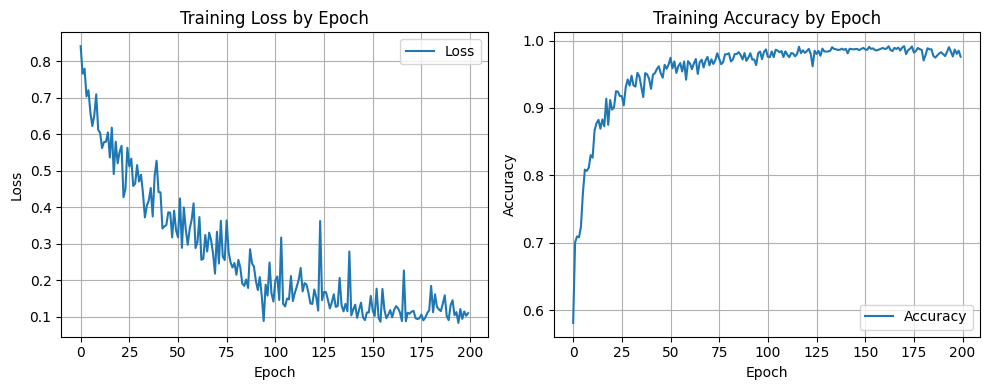

In [ ]:

print ("Model loading start")
# Model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1, activation=None)
model = model.to(device)

# Loss & Optimizer
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print ("Model loading complete")

# Training loop
train_loss_per_epoch = []
accuracy_per_epoch = []

num_epochs = 200
print("\n--- Epoch results ---")
#for epoch in range(30):
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == masks).sum().item()
        total += torch.numel(masks)

    train_loss_per_epoch.append(epoch_loss / len(train_loader))
    accuracy_per_epoch.append(correct / total)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {correct/total:.4f}")

# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
        masks = masks.numpy()

        y_true.extend(masks.reshape(-1))
        y_pred.extend(preds.reshape(-1))

# Compute Metrics
iou = jaccard_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- Evaluation Metrics ---")
print(f"IoU       : {iou:.4f}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_per_epoch, label='Loss')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_per_epoch, label='Accuracy')
plt.title('Training Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


# Model save/load directory

In [ ]:
import os
import torch

MODEL_DIR = r"/content/drive/MyDrive/Segmentation Model"
#MODEL_DIR = r"D:\OneDrive - The Pennsylvania State University\Research DATA\Zebrafish Data\ML models"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


# save model

In [ ]:
# At end of training loop
model_name = input("Enter a name for the trained model: ").strip()
model_path = os.path.join(MODEL_DIR, f"{model_name}.pt")
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Enter a name for the trained model: Model Ran 2nd time 
Model saved at /content/drive/MyDrive/Segmentation Model/Model Ran 2nd time.pt


#load the model

In [ ]:

# List available models
print("Available models:")
models = [f for f in os.listdir(MODEL_DIR) if f.endswith('.pt')]
for i, name in enumerate(models):
    print(f"{i + 1}. {name}")

# Ask user to pick one
choice = int(input("Enter the number of the model to load for prediction: ")) - 1
selected_model_path = os.path.join(MODEL_DIR, models[choice])

# Define model structure first
loaded_model = smp.Unet(in_channels=3, out_channels=1)  # Replace with your actual model class
loaded_model.load_state_dict(torch.load(selected_model_path, map_location=device))
loaded_model.to(device)
loaded_model.eval()

print(f"Loaded model: {models[choice]}")

Available models:
1. Best Model.pt
2. Model Ran 2nd time.pt
Enter the number of the model to load for prediction: 2
Loaded model: Model Ran 2nd time.pt



--- Evaluation Metrics ---
IoU       : 0.6598
Accuracy  : 0.9328
Precision : 0.7725
Recall    : 0.8188
F1 Score  : 0.7950


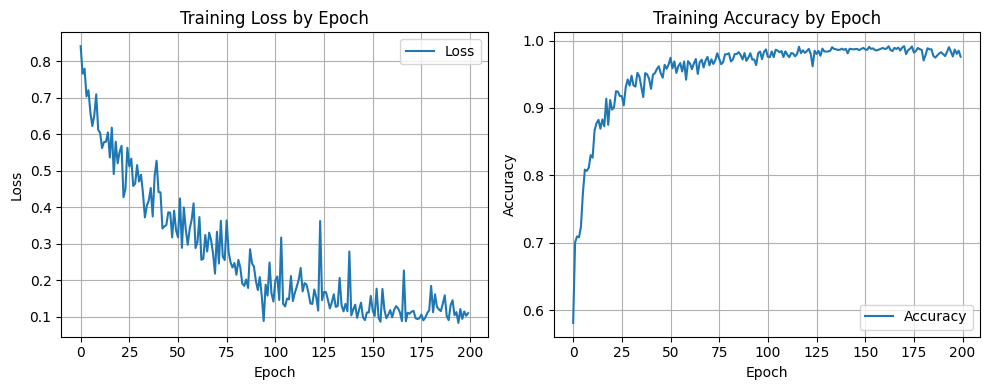

In [ ]:
# Evaluation
loaded_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = loaded_model(images)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
        masks = masks.numpy()

        y_true.extend(masks.reshape(-1))
        y_pred.extend(preds.reshape(-1))

# Compute Metrics
iou = jaccard_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- Evaluation Metrics ---")
print(f"IoU       : {iou:.4f}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_per_epoch, label='Loss')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_per_epoch, label='Accuracy')
plt.title('Training Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


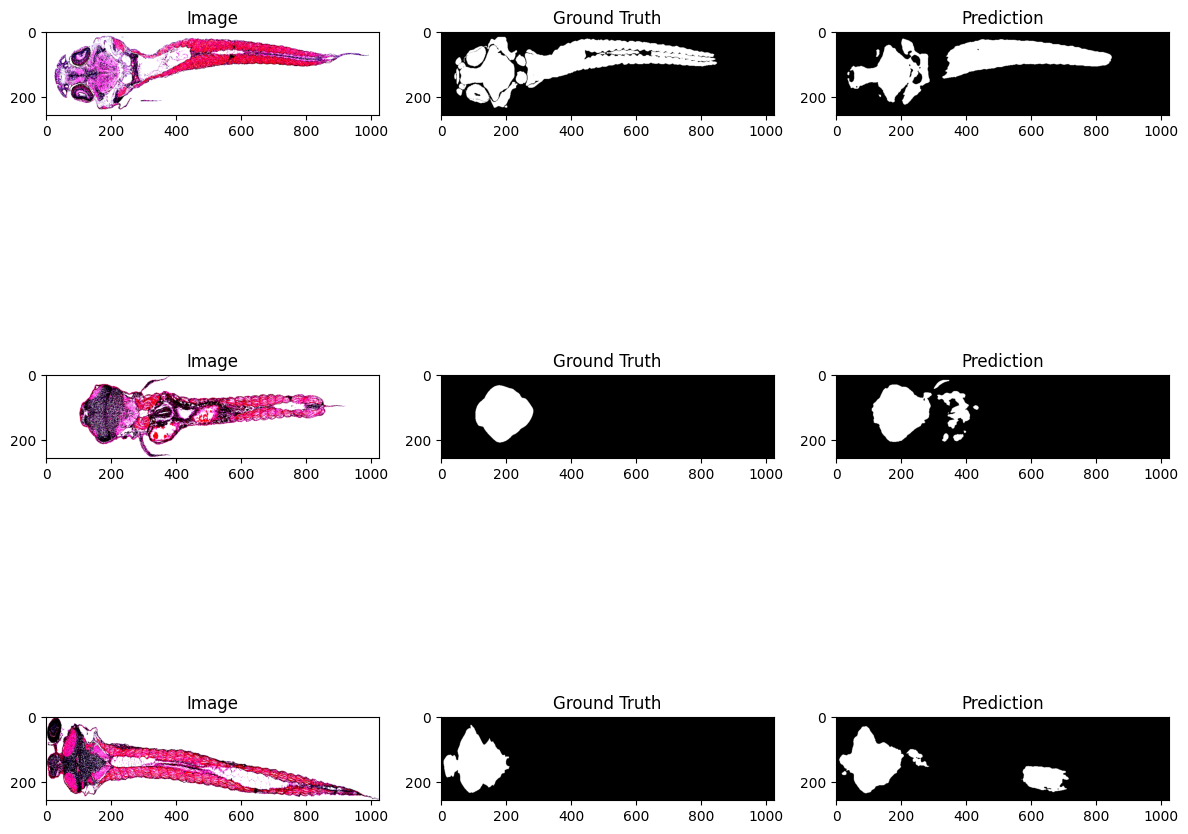

In [ ]:

# Show predictions
def show_prediction_examples(model, dataset, num=3):
    model.eval()
    plt.figure(figsize=(12, num * 4))
    for i in range(num):
        image, mask = dataset[i]
        with torch.no_grad():
            pred = torch.sigmoid(model(image.unsqueeze(0).to(device))).squeeze().cpu().numpy()
            pred_bin = (pred > 0.5).astype('float32')

        plt.subplot(num, 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Image")

        plt.subplot(num, 3, i*3+2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(num, 3, i*3+3)
        plt.imshow(pred_bin, cmap='gray')
        plt.title("Prediction")
    plt.tight_layout()
    plt.show()

show_prediction_examples(loaded_model, test_dataset, num=3)


[OK] Saved model_architecture_isometric.png


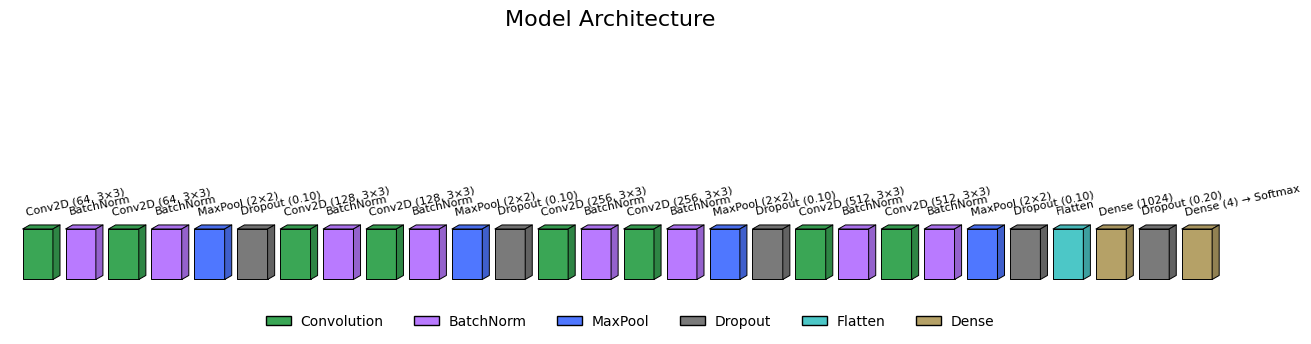

In [ ]:
# === Model Architecture (Isometric) — extra space between diagram and labels ===
# Run this cell/script to save: model_architecture_isometric.png (300 DPI)

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle, Patch
from matplotlib.collections import PatchCollection

# ---------- Appearance ----------
LAYER_COLORS = {
    "Conv":    "#3aa655",  # green
    "BN":      "#b97aff",  # purple
    "Pool":    "#4f77ff",  # blue
    "Dropout": "#7a7a7a",  # gray
    "Flatten": "#4cc7c7",  # teal
    "Dense":   "#b5a167",  # gold
}

# Isometric depth (pseudo-3D)
DEPTH_X = 0.28
DEPTH_Y = 0.16

# Block geometry & spacing
BLOCK_W = 1.2
BLOCK_H = 2.0
GAP     = 0.50   # spacing between blocks

# Fonts
FS_LABEL   = 8.0
FS_TITLE   = 16
FS_LEGEND  = 10

# ---------- EDIT THIS to match your network (order = left → right) ----------
layers = [
    # Stage 1
    ("Conv",    "Conv2D (64, 3×3)"), ("BN", "BatchNorm"),
    ("Conv",    "Conv2D (64, 3×3)"), ("BN", "BatchNorm"),
    ("Pool",    "MaxPool (2×2)"),    ("Dropout", "Dropout (0.10)"),
    # Stage 2
    ("Conv",    "Conv2D (128, 3×3)"), ("BN", "BatchNorm"),
    ("Conv",    "Conv2D (128, 3×3)"), ("BN", "BatchNorm"),
    ("Pool",    "MaxPool (2×2)"),     ("Dropout", "Dropout (0.10)"),
    # Stage 3
    ("Conv",    "Conv2D (256, 3×3)"), ("BN", "BatchNorm"),
    ("Conv",    "Conv2D (256, 3×3)"), ("BN", "BatchNorm"),
    ("Pool",    "MaxPool (2×2)"),     ("Dropout", "Dropout (0.10)"),
    # Stage 4
    ("Conv",    "Conv2D (512, 3×3)"), ("BN", "BatchNorm"),
    ("Conv",    "Conv2D (512, 3×3)"), ("BN", "BatchNorm"),
    ("Pool",    "MaxPool (2×2)"),     ("Dropout", "Dropout (0.10)"),
    # Head
    ("Flatten", "Flatten"),
    ("Dense",   "Dense (1024)"),
    ("Dropout", "Dropout (0.20)"),
    ("Dense",   "Dense (4) → Softmax"),
]

# ---------- Drawing helpers ----------
def _darker(c, f=0.85):
    import matplotlib.colors as mcolors
    r, g, b = mcolors.to_rgb(c)
    return (r*f, g*f, b*f)

def draw_block(ax, x, y, w, h, depth_x, depth_y, facecolor, edgecolor="black"):
    front = Rectangle((x, y), w, h)
    top   = Polygon([(x, y+h), (x+depth_x, y+h+depth_y),
                     (x+w+depth_x, y+h+depth_y), (x+w, y+h)])
    side  = Polygon([(x+w, y), (x+w+depth_x, y+depth_y),
                     (x+w+depth_x, y+h+depth_y), (x+w, y+h)])
    pc = PatchCollection(
        [front, top, side],
        facecolor=[facecolor, _darker(facecolor,0.92), _darker(facecolor,0.80)],
        edgecolor=edgecolor, linewidth=0.7
    )
    ax.add_collection(pc)

def add_label(ax, x, y, w, h, depth_x, depth_y, text):
    # label sits ABOVE the block; tweak the offset to increase gap if needed
    ax.text(x + w*0.08, y + h + depth_y + 0.32, text,
            fontsize=FS_LABEL, ha="left", va="bottom", rotation=12)

# ---------- Render ----------
def render_layers(layers, title="Model Architecture", out="model_architecture_isometric.png"):
    fig, ax = plt.subplots(figsize=(16, 6))  # a bit taller for breathing room
    x, y = 0.5, 1.6                          # raise baseline so legend can sit well below

    for kind, label in layers:
        color = LAYER_COLORS.get(kind, "#cccccc")
        draw_block(ax, x, y, BLOCK_W, BLOCK_H, DEPTH_X, DEPTH_Y, color)
        add_label(ax, x, y, BLOCK_W, BLOCK_H, DEPTH_X, DEPTH_Y, label)
        x += BLOCK_W + GAP

    # Title (centered)
    fig.suptitle(title, fontsize=FS_TITLE, y=0.97)

    # Centered legend with EXTRA vertical gap from diagram
    legend_items = [
        ("Conv","Convolution"), ("BN","BatchNorm"), ("Pool","MaxPool"),
        ("Dropout","Dropout"), ("Flatten","Flatten"), ("Dense","Dense")
    ]
    handles = [Patch(facecolor=LAYER_COLORS[k], edgecolor="black", label=name)
               for k, name in legend_items]

    # Make room at bottom and push legend further down
    plt.subplots_adjust(bottom=0.30)    # ↑ increase if you want even more space
    ax.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.22),    # ↓ move legend farther below the axes
        ncol=len(handles),
        frameon=False,
        fontsize=FS_LEGEND,
        columnspacing=2.2,
        handlelength=1.8,
        handletextpad=0.7,
        borderaxespad=0.8,
    )

    # Clean axes
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_xlim(0, x + 1.0)
    ax.set_ylim(0.3, y + BLOCK_H + 2.6)

    plt.savefig(out, dpi=300, bbox_inches="tight")
    print(f"[OK] Saved {out}")

# ---- run ----
render_layers(layers, title="Model Architecture", out="model_architecture_isometric.png")
